<a href="https://colab.research.google.com/github/prakhartiwari10/Colab-Notebooks/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Neural Networks Classification with Pytorch

In [ ]:
# Make classification data and get it ready
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

In [ ]:
X, y  = make_circles(n_samples,
                     noise=0.03,
                     random_state=42)
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [ ]:
# make dataframe of the circles data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "y": y})
circles

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


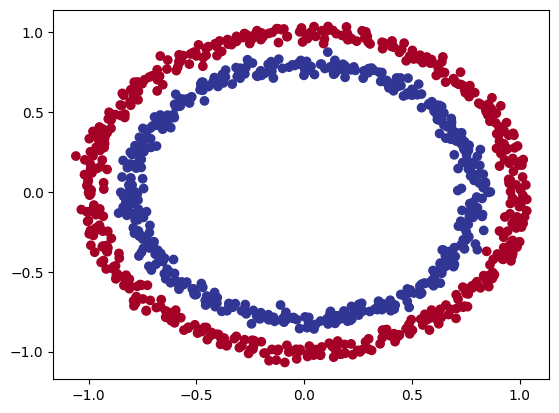

In [ ]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap = plt.cm.RdYlBu)

In [ ]:
# Check input and output shapes
X.shape, y.shape

((1000, 2), (1000,))

## Turn data into tensors and create train and test splits

In [ ]:
import torch
torch.__version__

'2.2.1+cu121'

In [ ]:
type(X)
type(y)

numpy.ndarray

In [ ]:
# Turn into tensors
X = torch.from_numpy(X).type(torch.float)

In [ ]:
y=torch.from_numpy(y).type(torch.float)
X.dtype, y.dtype

(torch.float32, torch.float32)

In [ ]:
torch.manual_seed(42)
# Split data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 2. Building a model
We'll build a classifier to classify blue and red dots, to do so, we want to:
1. Setup device agnostic code so our code will run on accelarator(GPU) if there is one available
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and testing loop.

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we'll build a model that'll:
1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shape of our data
3. Defines a `forward()` method that outlines the forward pass.
4. Instantiate an instance or our model class and send it to the target device

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

# Instantiate an instance of model and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer1.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer2.bias', tensor([-0.2060]))])

In [ ]:
# Replicate the same model in Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [ ]:
# Make predictions (without training)
untrained_preds = model_0(X_test.to(device))
print(untrained_preds[:10])
print(y_test)

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], grad_fn=<SliceBackward0>)
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,

In [ ]:
# setup loss function and optimizer
# loss_fn = nn.BCELoss() -> requires inputs to have gone through the sigmoid activation function prior
loss_fn = nn.BCEWithLogitsLoss()  # sigmoid function built in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Training the model

### 3.1 Going from raw logits ->prediction probabilities -> prediction labels
We can convert raw logits into prediction probability by passing them to some kind of activation function(eg. sigmoid for binary classification and softmax for multiclass classification)
Then we convert prediction probabilities to prediction labels by either rounding them or taking the `argmax()`

In [ ]:
# logits loss
model_0.eval
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
  print(y_logits)

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])


In [ ]:
# prediction probabilities using sigmoid
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In [ ]:
y_preds = torch.round(y_pred_prob)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Training and Testing Loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training

  model_0.train()
  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred, y_train)

  # optimizer zero grad
  optimizer.zero_grad()
  # loss backwards
  loss.backward()
  # optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}, | Test loss: {test_loss: .5f}, Test Acc: {test_acc}")


Epoch: 0 | Loss: 0.69796, Acc: 51.88, | Test loss:  0.69460, Test Acc: 57.49999999999999
Epoch: 10 | Loss: 0.69768, Acc: 52.00, | Test loss:  0.69438, Test Acc: 57.99999999999999
Epoch: 20 | Loss: 0.69742, Acc: 52.00, | Test loss:  0.69418, Test Acc: 57.49999999999999
Epoch: 30 | Loss: 0.69717, Acc: 52.00, | Test loss:  0.69401, Test Acc: 56.49999999999999
Epoch: 40 | Loss: 0.69695, Acc: 51.62, | Test loss:  0.69385, Test Acc: 56.49999999999999
Epoch: 50 | Loss: 0.69675, Acc: 51.38, | Test loss:  0.69370, Test Acc: 56.00000000000001
Epoch: 60 | Loss: 0.69656, Acc: 51.38, | Test loss:  0.69357, Test Acc: 56.00000000000001
Epoch: 70 | Loss: 0.69638, Acc: 51.38, | Test loss:  0.69345, Test Acc: 56.49999999999999
Epoch: 80 | Loss: 0.69621, Acc: 51.25, | Test loss:  0.69334, Test Acc: 56.49999999999999
Epoch: 90 | Loss: 0.69606, Acc: 51.38, | Test loss:  0.69324, Test Acc: 55.00000000000001


## 4. Make predictions and evaluate the model
we're going to import a function called `plot_decision_boundary()` from helper function of course from here: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [ ]:
import requests
from pathlib import Path

#Download helper functions from learn PyTorch repo ( if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("File already exists, skipping download")

else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

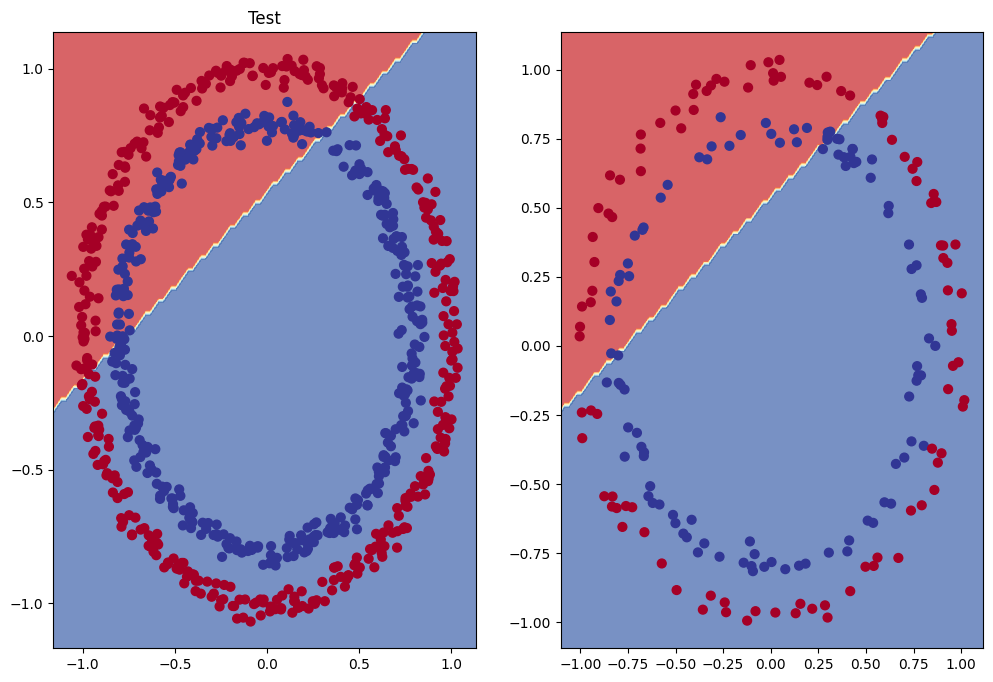

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.title("Test")
plt.subplot(1, 2, 2)
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model
* Add more layers - give chance to learn more patterns in data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the larning rate
* Change the loss function
Let's try following modifications:
epochs = 1000, increase number of hidden units from 5 to 10, and add an extra layer to our model

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device)
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310

In [ ]:
loss_fn = BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

NameError: name 'BCEWithLogitsLoss' is not defined

In [ ]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: .5f}, Accuracy : {acc: .2f} | Test loss: {test_loss: .5f}, Test accuracy: {test_acc: .2f}")

Epoch: 0 | Loss:  0.69528, Accuracy :  51.38 | Test loss:  0.69257, Test accuracy:  49.50
Epoch: 100 | Loss:  0.69528, Accuracy :  51.38 | Test loss:  0.69257, Test accuracy:  49.50
Epoch: 200 | Loss:  0.69528, Accuracy :  51.38 | Test loss:  0.69257, Test accuracy:  49.50
Epoch: 300 | Loss:  0.69528, Accuracy :  51.38 | Test loss:  0.69257, Test accuracy:  49.50
Epoch: 400 | Loss:  0.69528, Accuracy :  51.38 | Test loss:  0.69257, Test accuracy:  49.50
Epoch: 500 | Loss:  0.69528, Accuracy :  51.38 | Test loss:  0.69257, Test accuracy:  49.50
Epoch: 600 | Loss:  0.69528, Accuracy :  51.38 | Test loss:  0.69257, Test accuracy:  49.50
Epoch: 700 | Loss:  0.69528, Accuracy :  51.38 | Test loss:  0.69257, Test accuracy:  49.50
Epoch: 800 | Loss:  0.69528, Accuracy :  51.38 | Test loss:  0.69257, Test accuracy:  49.50
Epoch: 900 | Loss:  0.69528, Accuracy :  51.38 | Test loss:  0.69257, Test accuracy:  49.50


The model was trained for more layers with more hidden units and for more epochs, but still the results are like 50-50 like a coin toss
Let's visualize this model

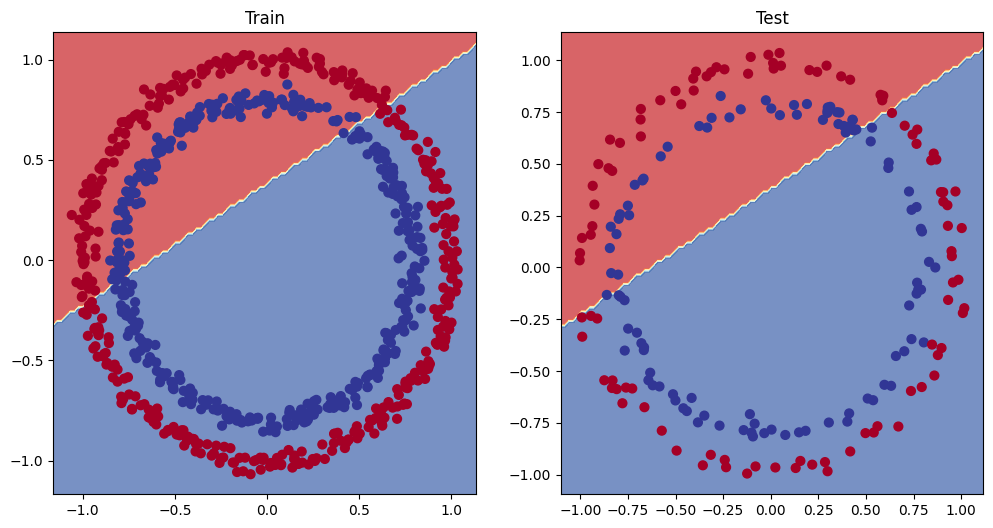

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title( "Test")
plot_decision_boundary(model_1, X_test, y_test)

Let's see if the model works on a custom linear dataset

In [ ]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = X_regression*weight + bias
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
train_split = int(0.8 * len(X_regression))
X_train_regression, X_test_regression = X_regression[:train_split], X_regression[train_split:]
y_train_regression, y_test_regression = y_regression[:train_split], y_regression[train_split:]
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

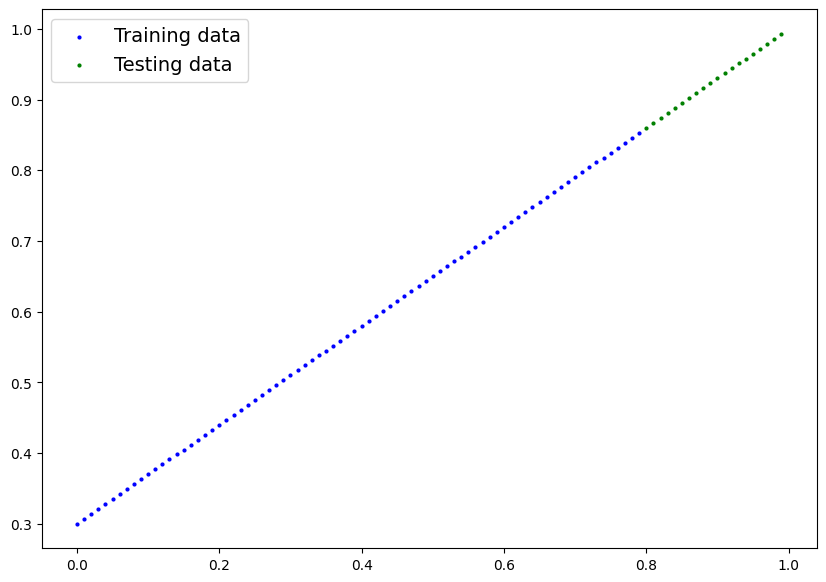

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [ ]:
# Adjusting mode_1 to fit a straight line by changing the input and output features to be 1 instead of 2
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [ ]:
# Train the model
torch.manual_seed(42)
epochs = 1000
# Put data into device
X_train_regression, X_test_regression, y_train_regression, y_test_regression = X_train_regression.to(device), X_test_regression.to(device), y_train_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  ## Training
  model_2.train()
  # forward
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ## Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch : {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:5f}")

Epoch : 0 | Loss: 0.75986 | Test loss: 0.541428
Epoch : 100 | Loss: 0.09309 | Test loss: 0.029012
Epoch : 200 | Loss: 0.07376 | Test loss: 0.028500
Epoch : 300 | Loss: 0.06745 | Test loss: 0.006152
Epoch : 400 | Loss: 0.06107 | Test loss: 0.020040
Epoch : 500 | Loss: 0.05698 | Test loss: 0.010608
Epoch : 600 | Loss: 0.04857 | Test loss: 0.013261
Epoch : 700 | Loss: 0.06109 | Test loss: 0.021269
Epoch : 800 | Loss: 0.05600 | Test loss: 0.014254
Epoch : 900 | Loss: 0.05571 | Test loss: 0.006033


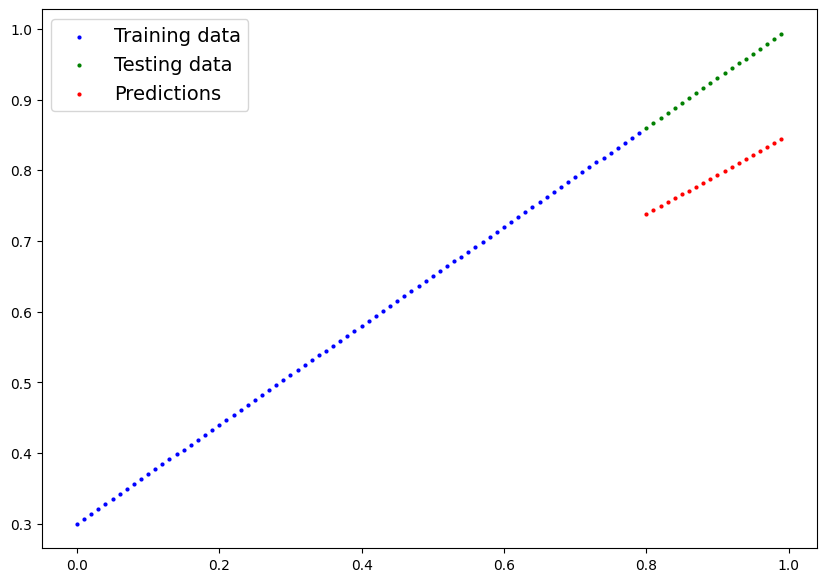

In [ ]:
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity
###      6.1 Recreating non-linear data(red and blue circles)

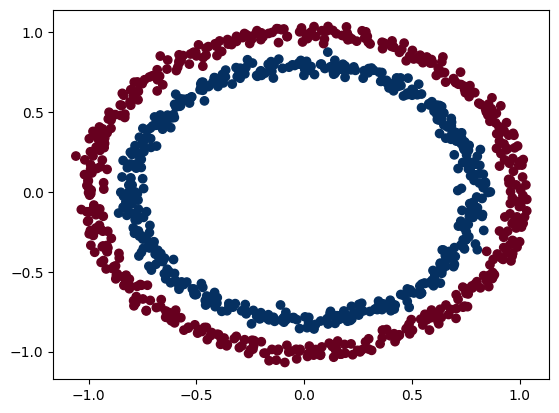

In [ ]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdBu)

In [ ]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:10], y[:10]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967],
         [-0.4796,  0.6764],
         [-0.0136,  0.8033],
         [ 0.7715,  0.1478],
         [-0.1693, -0.7935],
         [-0.1215,  1.0215]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [ ]:
# Training the model
torch.manual_seed(42)
epochs=1000
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_loss = loss_fn(test_logits, y_test)
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f"Epoch : {epoch} | Loss: {loss}, Accuracy: {acc} | Test_loss: {test_loss}, Test Accuracy: {test_acc}")


Epoch : 0 | Loss: 0.6929463148117065, Accuracy: 50.0 | Test_loss: 0.6931881904602051, Test Accuracy: 50.0
Epoch : 100 | Loss: 0.691152811050415, Accuracy: 52.87500000000001 | Test_loss: 0.6910240054130554, Test Accuracy: 52.5
Epoch : 200 | Loss: 0.6897743940353394, Accuracy: 53.37499999999999 | Test_loss: 0.6893961429595947, Test Accuracy: 55.00000000000001
Epoch : 300 | Loss: 0.687949538230896, Accuracy: 53.0 | Test_loss: 0.6872316598892212, Test Accuracy: 56.00000000000001
Epoch : 400 | Loss: 0.6851677894592285, Accuracy: 52.75 | Test_loss: 0.684114933013916, Test Accuracy: 56.49999999999999
Epoch : 500 | Loss: 0.6810224652290344, Accuracy: 52.75 | Test_loss: 0.6794120669364929, Test Accuracy: 56.49999999999999
Epoch : 600 | Loss: 0.675148606300354, Accuracy: 54.50000000000001 | Test_loss: 0.6728507876396179, Test Accuracy: 56.00000000000001
Epoch : 700 | Loss: 0.6665886044502258, Accuracy: 58.375 | Test_loss: 0.6632164716720581, Test Accuracy: 59.0
Epoch : 800 | Loss: 0.651595473289

In [ ]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_test)
  y_pred = torch.round(torch.sigmoid(y_logits)).squeeze()

y_pred[:10]

tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])

In [ ]:
import requests
from pathlib import Path

#Download helper functions from learn PyTorch repo ( if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("File already exists, skipping download")

else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

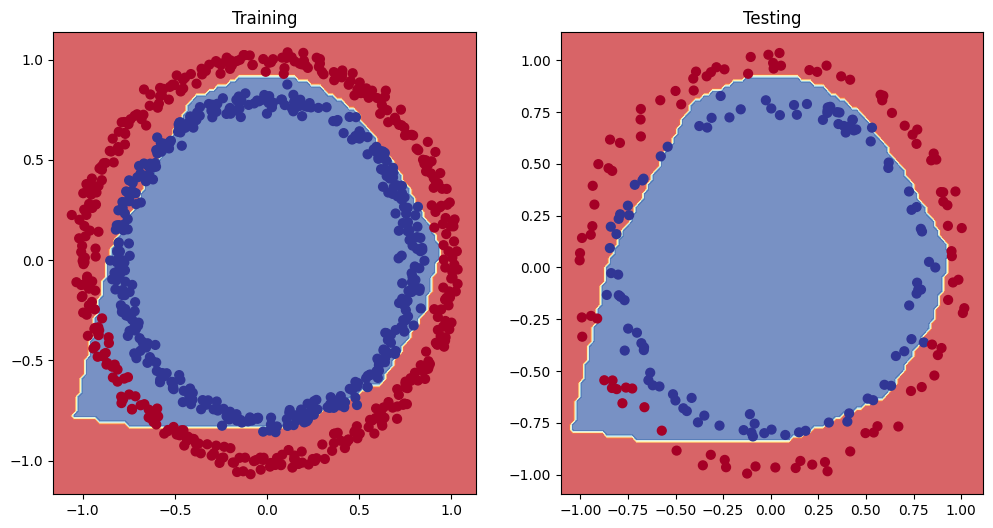

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Training")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [ ]:
A = torch.arange(-10, 10, 1, dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

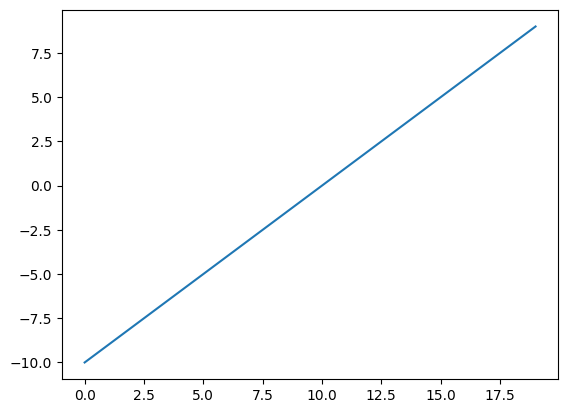

In [ ]:
plt.plot(A)

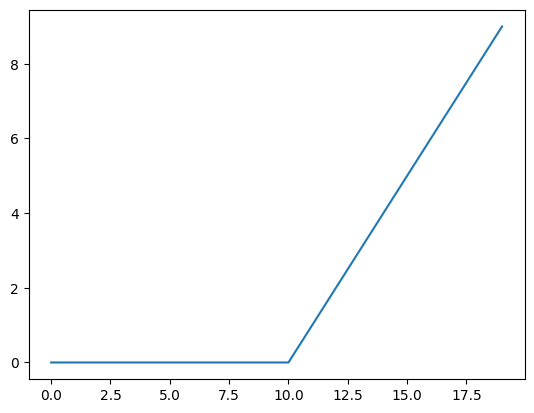

In [ ]:
def relu(x):
  return torch.maximum(torch.tensor(0), x )

plt.plot(relu(A))

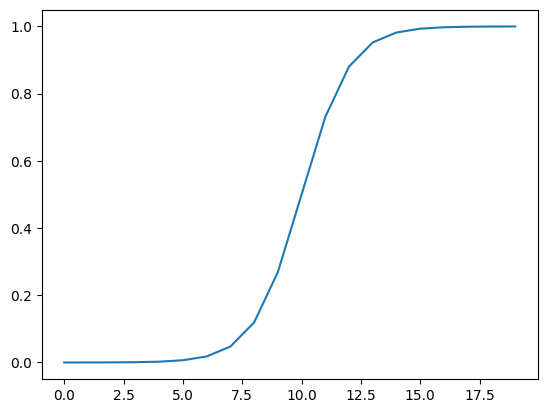

In [ ]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A))

## 8. Putting it all together by building a multi-class PyTorch Model

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


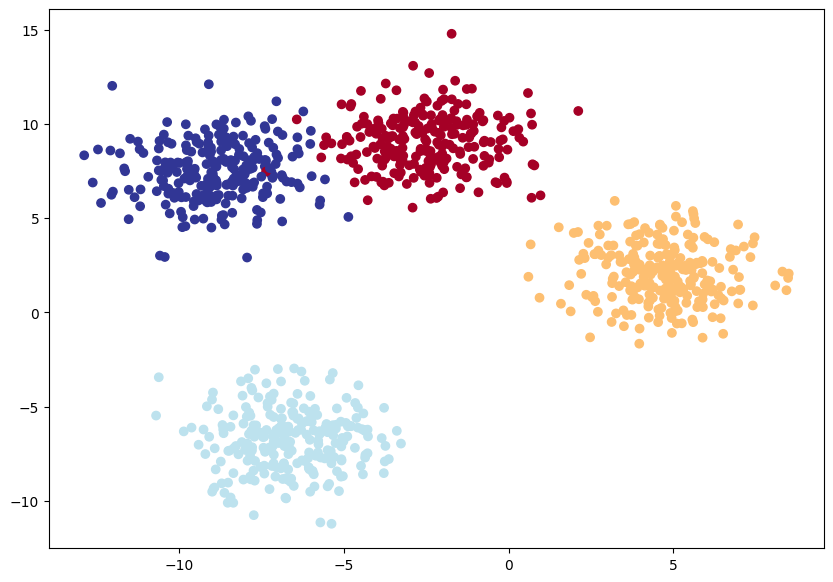

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Hyperparameters
NUM_CLASSES = 4
NUM_FEATURES =2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,test_size=0.2, random_state = RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap = plt.cm.RdYlBu)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(NUM_FEATURES, NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [ ]:
# what's the output of forward
y_logits = model_4(X_blob_test.to(device))
y_logits[:5]

tensor([[ 0.4528,  0.1330, -0.0628,  0.4125],
        [ 1.0411, -0.8237,  0.6075,  0.5312],
        [ 0.4205, -0.0189,  0.0507, -0.2789],
        [ 0.3116,  0.3156, -0.0779, -0.0467],
        [ 1.0608,  0.0112,  0.0746,  0.9427]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
# model is giving us logits for each classes to convert into probability and then prediction:-
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5 ]
y_prediction = torch.argmax(y_pred_probs[])
y_prediction

tensor(1, device='cuda:0')

In [ ]:
# Training
torch.manual_seed(42)
epochs = 100
X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_pred)

  if epoch%10==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 1.24231, Acc: 38.38% | Test Loss: 1.13088, Test acc: 57.00
Epoch: 10 | Loss: 0.56650, Acc: 98.75% | Test Loss: 0.54888, Test acc: 99.50
Epoch: 20 | Loss: 0.33480, Acc: 99.12% | Test Loss: 0.32841, Test acc: 99.50
Epoch: 30 | Loss: 0.20177, Acc: 99.00% | Test Loss: 0.19279, Test acc: 99.50
Epoch: 40 | Loss: 0.11932, Acc: 99.00% | Test Loss: 0.10975, Test acc: 99.50
Epoch: 50 | Loss: 0.08094, Acc: 99.00% | Test Loss: 0.07167, Test acc: 99.50
Epoch: 60 | Loss: 0.06329, Acc: 99.00% | Test Loss: 0.05403, Test acc: 99.50
Epoch: 70 | Loss: 0.05384, Acc: 99.00% | Test Loss: 0.04454, Test acc: 99.50
Epoch: 80 | Loss: 0.04805, Acc: 99.00% | Test Loss: 0.03870, Test acc: 99.50
Epoch: 90 | Loss: 0.04417, Acc: 99.00% | Test Loss: 0.03474, Test acc: 99.50


In [ ]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_pred_probs = torch.softmax(y_logits, dim=1)

y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


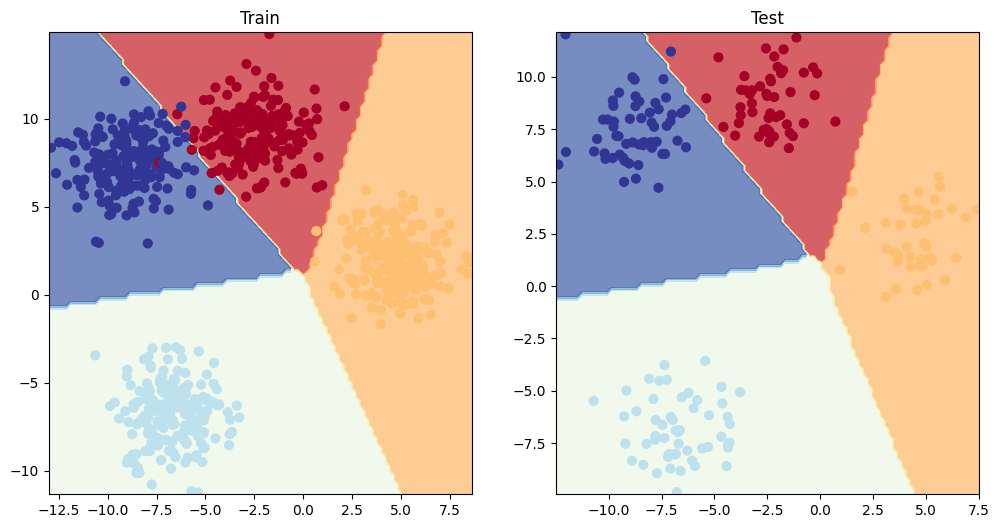

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# Metrics to measure:
1. Accuracy
2. Precision (tp/tp+fp)
3. Recall (tp/tp+fn) used to minimize false negative
4. f1 score (2*(precision*recall/precision+recall)) - gives harmonic mean of precision and recall
5. Confusion matrix
6. Classification report

In [ ]:
import sklearn.metrics as skm
accuracy_score = skm.accuracy_score(y_blob_test.to("cpu"), y_preds.to("cpu"))
precision_score = skm.precision_score(y_blob_test.to("cpu"), y_preds.to("cpu"), average='micro')
recall_score = skm.recall_score(y_blob_test.to("cpu"), y_preds.to("cpu"), average='micro')
confusion_matrix = skm.confusion_matrix(y_blob_test.to("cpu"), y_preds.to("cpu"))
print(accuracy_score, precision_score, recall_score, confusion_matrix)

0.995 0.995 0.995 [[49  0  0  0]
 [ 0 41  0  0]
 [ 0  0 53  0]
 [ 1  0  0 56]]


In [ ]:
skm.classification_report(y_blob_test.to("cpu"), y_preds.to("cpu"))

'              precision    recall  f1-score   support\n\n           0       0.98      1.00      0.99        49\n           1       1.00      1.00      1.00        41\n           2       1.00      1.00      1.00        53\n           3       1.00      0.98      0.99        57\n\n    accuracy                           0.99       200\n   macro avg       0.99      1.00      1.00       200\nweighted avg       1.00      0.99      1.00       200\n'